In [ ]:
#load all packages
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from keras import metrics
from keras.preprocessing import image

In [ ]:
BATCH_SIZE = 32
classes = ["not demented", "very mild demented", "mild demented", "moderate demented"]

class bcolors:
    OKGREEN = '\033[92m'
    ENDC = '\033[0m'
    WARNING = '\033[93m'

In [ ]:
# load dataset from drive
PATH = "/Users/robertklopsch/Desktop/Capstone_large_dataset/Alzheimer_s Dataset/train"
IMAGE_SIZE = (208, 176)
train_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=True, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=BATCH_SIZE)
                                        #validation_split=0.2,
                                        #subset="training")

# one hot encode the labels to fit into the cnn layers
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))


In [ ]:
# load dataset from drive
PATH = "/Users/robertklopsch/Desktop/Capstone_large_dataset/Alzheimer_s Dataset/validation"
IMAGE_SIZE = (208, 176)
val_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=False, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=BATCH_SIZE)
                                        #validation_split=0.2,
                                        #subset="validation")

# one hot encode the labels to fit into the cnn layers
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))

In [ ]:
for i,t in val_ds.take(1):
    print(i.mean)
    print(i[0].shape)

In [ ]:
# # plot some example images from loaded set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title([labels[i].numpy()][0])
    plt.axis("off")

In [ ]:
#iniziating model architecture
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(208, 176, 3)))

model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(50, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

In [ ]:
#add dense layes to conv layers
model.add(layers.Flatten())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(16, activation='relu'))

model.add(layers.Dense(4, activation="softmax"))

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=train_ds.cardinality().numpy()*100,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')

In [ ]:
#compiling the model architecture and start fit
keras.backend.clear_session()
model.compile(optimizer=optimizer,
              loss="CategoricalCrossentropy",
              metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC(), metrics.Accuracy()])

with tf.device("/gpu:0"):
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=10)

In [ ]:
#print val vs accuracy
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Make predictions with validation set
y_pred = model.predict(val_ds)

In [ ]:
# Convert tensor to numpy array to make it accessible 
array = tfds.as_numpy(val_ds)

In [ ]:
# Extract actual labels from val_ds tensor
actual_labels = []
for images, labels in array:
    for label in labels:
        actual_labels.append(classes[np.argmax(label)])

# Extract labels from predictions
predicted_labels = []
for label in y_pred:
    predicted_labels.append(classes[np.argmax(label)])

In [ ]:
# Calculate correct and wrong predictions per class
correct_values = {"not demented" : 0, "very mild demented" : 0, "mild demented" : 0, "moderate demented" : 0}
wrong_values = {"not demented" : 0, "very mild demented" : 0, "mild demented" : 0, "moderate demented" : 0}

for labels in zip(actual_labels, predicted_labels):
    if labels[0] == labels[1]:
        correct_values.update([(labels[0], correct_values[labels[0]] + 1)])
    else:
        wrong_values.update([(labels[0], wrong_values[labels[0]] + 1)])   

In [45]:
data = [[correct_values[classes[0]] + wrong_values[classes[0]], correct_values[classes[0]], wrong_values[classes[0]], round(correct_values[classes[0]] / (correct_values[classes[0]] + wrong_values[classes[0]]) * 100, 2), "%"],
        [correct_values[classes[1]] + wrong_values[classes[1]], correct_values[classes[1]], wrong_values[classes[1]], round(correct_values[classes[1]] / (correct_values[classes[1]] + wrong_values[classes[1]]) * 100, 2), "%"],
        [correct_values[classes[2]] + wrong_values[classes[2]], correct_values[classes[2]], wrong_values[classes[2]], round(correct_values[classes[2]] / (correct_values[classes[2]] + wrong_values[classes[2]]) * 100, 2), "%"],
        [correct_values[classes[3]] + wrong_values[classes[3]], correct_values[classes[3]], wrong_values[classes[3]], round(correct_values[classes[3]] / (correct_values[classes[3]] + wrong_values[classes[3]]) * 100, 2), "%"]]

headers = ["  Total", "  Correct", "   Wrong", "   Accuracy", ""]
rows = ["Not demented", "Very mild demented", "Mild demented", "Moderate demented"]

print(pd.DataFrame(data, rows, headers))

                      Total    Correct     Wrong     Accuracy   
Not demented            513        500        13        97.47  %
Very mild demented      359        351         8        97.77  %
Mild demented           144        135         9        93.75  %
Moderate demented        11          0        11         0.00  %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

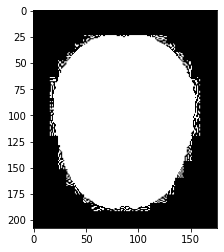

In [85]:
for images, labels in train_ds:
    for i in images:
        plt.imshow(i)

In [ ]:
#!mkdir -p saved_model2
#model.save("saved_model/model2")